# Library

In [1]:
import pandas as pd
import matplotlib
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import enchant
import jellyfish
from pattern.en import suggest
from time import time
import multiprocessing


In [2]:
print(f'Pandas version : {pd.__version__}')
print(f'Matplotlib version : {matplotlib.__version__}')
print(f'Seaborn version : {sns.__version__}')
print(f'NLTK version : {nltk.__version__}')
print(f'Enchant version : {enchant.__version__}')


Pandas version : 1.0.3
Matplotlib version : 3.2.1
Seaborn version : 0.10.1
NLTK version : 3.5
Enchant version : 2.0.0


# Manage dataset

In [3]:
df_a = pd.read_csv('./dataset/1_ocr_text/train_ocr_1.csv', header=None)
df_b = pd.read_csv('./dataset/1_ocr_text/train_ocr_2.csv', header=None)
df_c = pd.read_csv('./dataset/1_ocr_text/train_ocr_3.csv', header=None)
df_d = pd.read_csv('./dataset/1_ocr_text/train_ocr_4.csv', header=None)
df_d


,0
0,"['meoka', 'nusata', 'aya', 'smiossls', 'diao']"
1,[]
2,"['ongkir', 'sejabodstabe', 'fee', 'bed', 'mini..."
3,"['11', '12', '15', '135']"
4,['naocemalu']
...,...
26343,"['s', 'n', 's', 'nnss']"
26344,"['dunia', 'fashion', 'aigner', 'g', 'l']"
26345,"['hikarihousld', 'v']"
26346,"['r', 'iming']"


In [4]:
df = pd.concat([df_a, df_b, df_c, df_d], axis=0, ignore_index=True)
df.columns = ['words']

def to_list(words):
    if words == '[]':
        return []
    else:
        words = words.strip('"')
        words = words.strip('[')
        words = words.strip(']')
        words = words.split(',')
        words = [w.lstrip(' ') for w in words]
        words = [w.strip("'") for w in words]
        words = [w for w in words if w != '']

        return words

df['words'] = df['words'].apply(to_list)
df


,words
0,"[tteieso, eataltiae]"
1,"[anti, oeia, s, caa, club]"
2,"[lelod, dior, hello, by, b, e]"
3,"[jlayuuy, c, aeteztdlia, reris, sueon, sgite]"
4,"[euted, ceaee]"
...,...
105385,"[s, n, s, nnss]"
105386,"[dunia, fashion, aigner, g, l]"
105387,"[hikarihousld, v]"
105388,"[r, iming]"


In [5]:
df_train = pd.read_csv('./dataset/0_original_csv/train.csv')
df_train


,filename,category
0,45e2d0c97f7bdf8cbf3594beb6fdcda0.jpg,3
1,f74d1a5fc2498bbbfa045c74e3cc333e.jpg,3
2,f6c172096818c5fab10ecae722840798.jpg,3
3,251ffd610399ac00fea7709c642676ee.jpg,3
4,73c7328b8eda399199fdedec6e4badaf.jpg,3
...,...,...
105385,047a60001de0331608ba64092cc7ae2b.jpg,25
105386,ea39ac66ccdc4b4d4c6443f6c54d8ae3.jpg,25
105387,6215f8c52c5bbcfe3e63e0f3ac6265f8.jpg,25
105388,1733d8286f6658149c7b7cdeb40d6461.jpg,25


In [6]:
df = pd.concat([df_train, df], axis=1, ignore_index=True)
df.columns = ['filename', 'category', 'words']
df


,filename,category,words
0,45e2d0c97f7bdf8cbf3594beb6fdcda0.jpg,3,"[tteieso, eataltiae]"
1,f74d1a5fc2498bbbfa045c74e3cc333e.jpg,3,"[anti, oeia, s, caa, club]"
2,f6c172096818c5fab10ecae722840798.jpg,3,"[lelod, dior, hello, by, b, e]"
3,251ffd610399ac00fea7709c642676ee.jpg,3,"[jlayuuy, c, aeteztdlia, reris, sueon, sgite]"
4,73c7328b8eda399199fdedec6e4badaf.jpg,3,"[euted, ceaee]"
...,...,...,...
105385,047a60001de0331608ba64092cc7ae2b.jpg,25,"[s, n, s, nnss]"
105386,ea39ac66ccdc4b4d4c6443f6c54d8ae3.jpg,25,"[dunia, fashion, aigner, g, l]"
105387,6215f8c52c5bbcfe3e63e0f3ac6265f8.jpg,25,"[hikarihousld, v]"
105388,1733d8286f6658149c7b7cdeb40d6461.jpg,25,"[r, iming]"


# Analyse (Before text processing)

In [7]:
total_images_with_words = 0

def check_word_exist(words):
    global total_images_with_words
    if len(words) > 0:
        total_images_with_words += 1

df['words'].map(check_word_exist)

print(f'Total images : {len(df.index)}')
print(f'Total images with words : {total_images_with_words} ({total_images_with_words / len(df.index)})')


Total images : 105390
Total images with words : 83588 (0.7931302780149919)


In [8]:
dict_word = {}

def count_word_occurance(words):
    global dict_word
    for w in words:
        if w not in dict_word:
            dict_word[w] = 1
        else:
            dict_word[w] += 1

df['words'].map(count_word_occurance)

words_freq = []
for i in [1, 2, 3, 4, 5, 10, 15, 20, 25, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]:
    common_words_occurance = {k: v for k, v in dict_word.items() if v >= i}
    words_freq.append((i, len(common_words_occurance)))

words_freq = pd.DataFrame(words_freq, columns=['Frequency', 'Total'], dtype='int32')


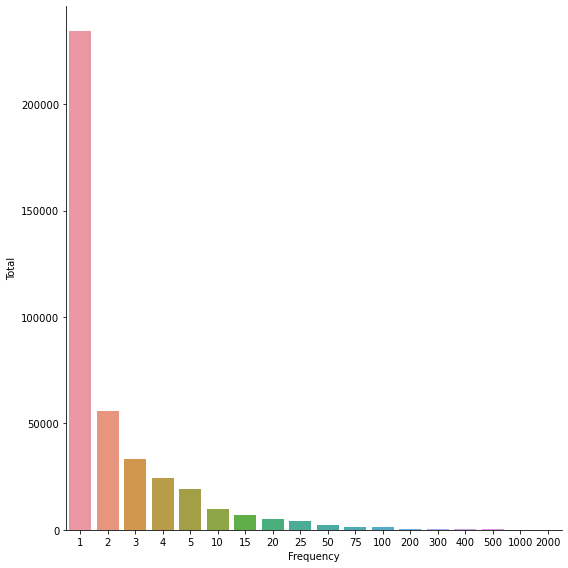

In [9]:
sns.catplot(x='Frequency', y='Total', kind='bar',
            data=words_freq, height=8, aspect=1)


# Process text
 > Dynamic programming is used to save time

## 1. remove words with occurance less than 5

In [10]:
words_list = list(dict_word.keys())
for word in words_list:
    if dict_word[word] < 5:
        del dict_word[word]

print(f'Total words after process 1 : {len(dict_word.keys())}')


Total words after process 1 : 19269


## 2. filter words
 1. Remove non char
 2. Check word length is > 3
 3. Check word in english dict & not in english stopwords
 4. Check word in indonesian dict & not in indonesian stopwords
 5. Check possible typos with words in english dict & not in english stopwords
 6. Check possible typos with words in indonesia dict & not in indonesian stopwords

In [11]:
eng_stopwords = nltk.corpus.stopwords.words('english')
ind_stopwords = nltk.corpus.stopwords.words('indonesian')

eng_dict = enchant.Dict('en')
ind_dict = enchant.Dict('id_ID')

# prevent weird bug calling suggest for first time
try:
    suggest('cocoa')
except:
    pass


In [12]:
def suggest_word(word, lang):
    if lang == 'eng':
        word_suggestion = suggest(word)
        if 0.6 < word_suggestion[0][1] < 1:
            return word_suggestion[0][0]
        return None
    else:
        word_suggestion = ind_dict.suggest(word)

        ws_index = -1
        ws_distance = 3 # means max allowed distance = 2
        for i in range(len(word_suggestion)):
            curr_distance = jellyfish.levenshtein_distance(word, word_suggestion[i])
            if curr_distance < ws_distance:
                ws_index = i
                ws_distance = curr_distance
        if ws_index != -1:
            return word_suggestion[ws_index]
        return None


In [13]:
def filter_word(word):
    # 1
    word = re.sub('[^a-z]', '', word)
    # 2
    if len(word) < 4:
        return None
    # 3
    if eng_dict.check(word):
        if word not in eng_stopwords:
            return (word, word)
        return None
    # 4
    if ind_dict.check(word):
        if word not in ind_stopwords:
            return (word, word)
        return None
    # 5
    suggested_word = suggest_word(word, lang='eng')
    if suggested_word is not None:
        if suggested_word not in eng_stopwords:
            return (word, suggested_word)
        return None
    # 6
    # suggested_word = suggest_word(word, lang='ind')
    # if suggested_word is not None:
    #     if suggested_word not in ind_stopwords:
    #         return (word, suggested_word)
    #     return None
    return None


In [14]:
words_list = list(dict_word.keys())
with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
    START_TIME = time()

    words_memoization_list = pool.map(filter_word, words_list)

    END_TIME = time()
    print(f'Process 2 took {END_TIME - START_TIME} seconds')

words_memoization = {}
for word in words_memoization_list:
    if word is not None:
        words_memoization[word[0]] = word[1]

print(f'Total words after process 2 : {len(words_memoization.keys())}')


Process 2 took 60.34605002403259 seconds
Total words after process 2 : 8358


## 3. apply changes to dataframe

In [15]:
def apply_memoization(words):
    global words_memoization
    new_words = []
    for w in words:
        if w in words_memoization:
            new_words.append(words_memoization[w])
    return new_words


In [16]:
df['words'] = df['words'].apply(apply_memoization)
df


,filename,category,words
0,45e2d0c97f7bdf8cbf3594beb6fdcda0.jpg,3,[]
1,f74d1a5fc2498bbbfa045c74e3cc333e.jpg,3,"[anti, club]"
2,f6c172096818c5fab10ecae722840798.jpg,3,"[door, hello]"
3,251ffd610399ac00fea7709c642676ee.jpg,3,[]
4,73c7328b8eda399199fdedec6e4badaf.jpg,3,[]
...,...,...,...
105385,047a60001de0331608ba64092cc7ae2b.jpg,25,[]
105386,ea39ac66ccdc4b4d4c6443f6c54d8ae3.jpg,25,"[dunia, fashion]"
105387,6215f8c52c5bbcfe3e63e0f3ac6265f8.jpg,25,[]
105388,1733d8286f6658149c7b7cdeb40d6461.jpg,25,[]


In [17]:
df.to_csv('./dataset/2_with_cleaned_text/train.min.csv', index=False)


# Analyse (After text processing)

In [18]:
total_images_with_words = 0

df['words'].map(check_word_exist)

print(f'Total images : {len(df.index)}')
print(f'Total images with words : {total_images_with_words} ({total_images_with_words / len(df.index)})')


Total images : 105390
Total images with words : 50541 (0.47956162823797327)


In [19]:
dict_word = {}

df['words'].map(count_word_occurance)

words_freq = []
for i in [5, 10, 15, 20, 25, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]:
    common_words_occurance = {k: v for k, v in dict_word.items() if v >= i}
    words_freq.append((i, len(common_words_occurance)))

words_freq = pd.DataFrame(words_freq, columns=['Frequency', 'Total'], dtype='int32')


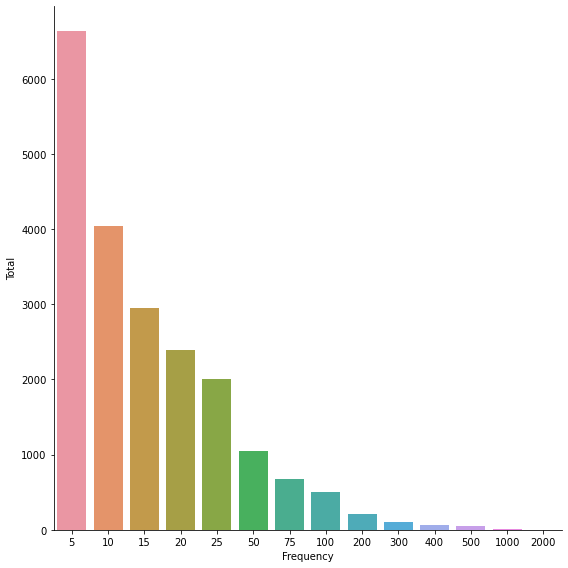

In [20]:
sns.catplot(x='Frequency', y='Total', kind='bar',
            data=words_freq, height=8, aspect=1)
